# Cogs 109: Modeling and Data Analysis
## Final project guidelines, 2019

Work in teams of at least 2 and no more than 4 students. Every student in the group will be expected to contribute substantially to the final product(s), and all students should be able to understand and explain all aspects of the project when you present your work in the final symposium.

Your project should. 
- Identify a real problem, challenge or scientific question which could benefit from data analysis and modeling. Your final report must explain why the question is interesting or important. 
- Identify a relevant data set. You should learn about how the data was collected and be able to explain key features of the data, for example: How many observations? What are the noise sources? What are the relevant predictors?
Identify at least one relevant data analysis approach, choosing from the methods covered in the course (linear or nonlinear regression, classification, clustering, PCA, etc.). Explain why this analysis approach is appropriate for addressing your question.
- Identify and explain one or more hypotheses or initial expectation that you will test using the data.
- Model selection: You should compare and contrast multiple different models (at least 2, but usually more). Your comparison should make use of cross-validation, bootstrap sampling, regularization, and/or other relevant techniques. For example, you might compare K-Nearest Neighbors classification for a range of k values (k=1,2,…,50), and select the k value that provides the lowest test set (cross-validation) error.
- Model estimation: Implement your data analysis and present the results using a combination of data visualizations (box plots, scatter plots), statistical analyses and models.
- Present your conclusions and outlook for next steps/future directions.

The final product will be a written report, 5-10 pages in length. In addition, you will create a poster explaining your project to be presented in a symposium session on the last day of class. We will provide more information about the final paper and poster in a few weeks.


## Written report:
Your final report must include the following sections (use these headings).
- Introduction. 
    - Define the real problem and explain its motivation
    - Identify the dataset you will use and explain its key characteristics.
    - Explain at least one hypothesis that you will test.
- Methods. Identify the data analysis approach you will use and explain the rationale/motivation for your choice of this approach.
- Results
    - Model selection. You MUST compare at least 2 models, using cross-validation, regularization, and/or other relevant techniques.
    - Model estimation. What are the final parameter estimates? What is the final accuracy of the model’s predictions?
    - Conclusions and discussion. What can you conclude about your hypothesis? (Note that negative or ambiguous results are perfectly acceptable, you just need to explain what you found.) What are some potential implications/next steps for researchers interested in this topic?


In [7]:
import requests
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm
from scipy import linalg
from sklearn.linear_model import Ridge
from pytrends.request import TrendReq
import os.path
from sklearn.preprocessing import StandardScaler

In [8]:
# From https://stackoverflow.com/questions/50786266/writing-dictionary-of-dataframes-to-file
import csv
import pandas as pd

def save_dict_df(dictex, keys_filename="keys.txt", data_folder="stock_data"):
    for key, val in dictex.items():
        val.to_csv("./"+data_folder+"/data_{}.csv".format(str(key)))

    with open(keys_filename, "w") as f: #saving keys to file
        f.write(str(list(dictex.keys())))

def load_dict_df(keys_filename="keys.txt", data_folder="stock_data"):
    """Reading data from keys"""
    with open(keys_filename, "r") as f:
        keys = eval(f.read())

    dictex = {}    
    for key in keys:
        dictex[key] = pd.read_csv("./"+data_folder+"/data_{}.csv".format(str(key)), index_col=0)

    return dictex

In [9]:
companies = ['tesla', 'facebook', 'microsoft', 'amazon', 'google', 'uber', 'lyft', 'apple', 'snap']
key_terms = ['report', 'good', 'bad', 'up', 'down', 'stock']
company_symbol = ['TSLA', 'FB', 'MSFT', 'AMZN', 'GOOGL', 'UBER', 'LYFT', 'AAPL', 'SNAP']

In [10]:
#create kw_list 
kw_list = []
for c_name in companies:
    for k in key_terms:
        kw_list.append(c_name + " " + k)

In [36]:
# Get 3-month ago trend data. May need to run a couple times to make sure it doesn't time out. 
def getTrendDataDF(kw_list, pull_data=False, dates='today 3-m', pytrends_df_filename="pytrends.csv"):
    # Retrieve the cached trend data
    if not pull_data and os.path.isfile(pytrends_df_filename):
        df = pd.read_csv(pytrends_df_filename, index_col="date")
        
    else: # Construct the dataframe by making pytrends calls
        df = pd.DataFrame()
        #print(df.empty)
        pytrends = TrendReq(hl='en-US', tz=360)
        for kw in kw_list:
            pytrends.build_payload([kw], cat=0, timeframe=dates, geo='', gprop='')
            df_temp = pytrends.interest_over_time()
            df_temp = df_temp.drop(['isPartial'], axis=1)
            # print(kw)
            if df.empty:
                df = df_temp
            else:
                df = df.join(df_temp)
        df.to_csv(pytrends_df_filename)
    #reverse df rows
    df = df.iloc[::-1]
    return df

In [62]:
# Get Stock Daily info for past 100 days
def getDailyStockInfoDict(company_symbol, pull_data=False, stock_df_filename="stock_keys.txt"):
    if not pull_data and os.path.isfile(stock_df_filename):
        dict_stocks = load_dict_df(keys_filename=stock_df_filename);
    else :
        ts = 'TIME_SERIES_DAILY'
        api_key = ''
        outputsize = 'compact'
        dict_stocks = {}
        for i, symbol in enumerate(company_symbol):
            link = 'https://www.alphavantage.co/query?function={}&symbol={}&apikey={}&outputsize={}'\
                    .format(ts, symbol, api_key, outputsize)
            r = requests.get(link)
            data = json.loads(r.text)
            # API only give you 5 requests per 5 mins, so break out if response is not what is expected.
            if "Time Series (Daily)" not in data:
                break
            stock_data_per_day = json.dumps(data["Time Series (Daily)"])
            df_temp = pd.read_json(stock_data_per_day).transpose()
            df_temp.reset_index(level=0, inplace=True)
            df_temp.columns = ['times', 'open', 'high', 'low', 'close', 'volume']
            dict_stocks[companies[i]] = df_temp
        save_dict_df(dict_stocks, keys_filename=stock_df_filename)
    return dict_stocks

In [63]:
def getTrends(company_name, df_trends):
    # Filters the trends
    company_keywords =  [x for x in list(df_trends.columns.values) if company_name in x]
    return df_trends[company_keywords].copy()
    

In [64]:
def getJointTimes(df_stock, df_trends): 
    stock_times = df_stock['times']
    trends_times = list(df_trends.index)
    return list(set(stock_times) & set(trends_times)) 

In [65]:
def getOverlapDateData(company_name, dict_stocks, df_trends): 
    new_df_trends = getTrends(company_name, df_trends)
    
    joint_times = getJointTimes(dict_stocks[company_name], new_df_trends)
    
    new_df_stocks = dict_stocks[company_name].loc[dict_stocks[company_name]['times'].isin(joint_times)]
    new_df_stocks = new_df_stocks.reset_index() 
    
    new_df_trends = new_df_trends.loc[new_df_trends.index.isin(joint_times)]
    new_df_trends = new_df_trends.reset_index()
    new_df_trends.columns = ['_'.join(x.split()) for x in list(new_df_trends.columns) if len(x) > 1]
    df_all_data = new_df_stocks.join(new_df_trends)
    return df_all_data


In [66]:
def trainMultipleRegression(y_col, parameter_cols, training_data): 
    formula = y_col + ' ~ 1'
    for i in parameter_cols: 
        formula = formula + " + " + i

    result = sm.formula.ols(formula=formula, data=training_data).fit()
    return result

In [136]:
def plotMultipleRegressionAndGetMSE(result, y_col, cols, all_data, training_data, testing_data):
    #y_pred = result.predict()
    #     plt.plot(range(len(all_data[y_col])) , all_data[y_col])
    #     plt.plot(range(50), result.predict(training_data[cols]), '-')
    #     plt.plot(range(50, len(df_all_data[y_col])), result.predict(testing_data[cols]), '-')
    #     plt.xlabel('Day')
    #     plt.ylabel('Output $ amount')
    #     plt.title('Multiple Regression: ' + str(y_col))
    #     plt.legend(["True Data","Training Data - Price change prediction", "Testing Data - Price change prediction"])
    #     plt.show()
    
    MSE = np.sum(np.power(result.predict(testing_data[cols]) - testing_data[y_col], 2))
    return MSE

In [137]:
def getBestAlphaRidgeRegression(y_col, parameter_cols, df_all_data_train):
    df_all_data_test = df_all_data_train[40:]
    df_all_data_train = df_all_data_train[:40]
    
    X = df_all_data_train[parameter_cols]
    y = df_all_data_train[y_col]
    alpha = []
    MSE_train = []
    MSE_test = []
    for i in range(90, 10000, 10):
        clf = Ridge(alpha=i)
        clf.fit(X, y) 
        alpha.append(i)
        MSE_train.append(mean_squared_error(clf.predict(df_all_data_train[cols]), df_all_data_train[y_col]))
        MSE_test.append(mean_squared_error(clf.predict(df_all_data_test[cols]), df_all_data_test[y_col]))

    bestAlpha = alpha[MSE_test.index(min(MSE_test))]
    
    print("alpha: "+str(bestAlpha))
    print("Training error = "+str(mean_squared_error(clf.predict(df_all_data_train[cols]), df_all_data_train[y_col])))
    print("Testing error = "+str(mean_squared_error(clf.predict(df_all_data_test[cols]), df_all_data_test[y_col])))
    print()
    return bestAlpha, clf

In [138]:
#ridge regression

def trainAndPlotRidgeRegressionAndReturnMSE(y_col, parameter_cols, df_all_data_train, df_all_data_test) : 
    bestAlpha, clf = getBestAlphaRidgeRegression(y_col, parameter_cols, df_all_data_train)
    
    X = df_all_data_train[parameter_cols]
    y = df_all_data_train[y_col]
    
    #plot data with training and test data
    clf = Ridge(alpha=bestAlpha)
    clf.fit(X, y) 
    #     plt.plot(range(len(df_all_data[y_col])) , df_all_data[y_col])
    #     plt.plot(range(50), clf.predict(df_all_data_train[cols]), '-')
    #     plt.plot(range(50, len(df_all_data[y_col])), clf.predict(df_all_data_test[cols]), '-')
    #     plt.xlabel('Day')
    #     plt.ylabel('Output $ amount')
    #     plt.title('Ridge Regression: ' + str(y_col))
    #     plt.legend(["True Data","Training Data - Price change prediction", "Testing Data - Price change prediction"])
    #     plt.show()
    
    MSE = np.sum(np.power(clf.predict(df_all_data_test[cols]) - df_all_data_test[y_col], 2))
    return MSE

In [139]:
def getMovingAvgAndStdDev(col_name, num_days, df_all_data):
    # Moving average and stdev past X days
    col_movingAvg = []
    col_stdev = []
    
    num_days_to_average = 10
    for i in range(len(df_all_data)):
        sum_to_avg = 0
        nums = []
        num_to_avg = min(num_days_to_average, len(df_all_data) - i) - 1
        for j in range(1, num_to_avg):
            sum_to_avg += df_all_data[col][i + j]
            nums.append(df_all_data[col][i + j])
        avg = sum_to_avg / (num_to_avg if num_to_avg > 0 else 1)
        stdev = np.std((nums if nums else [0]))

        col_movingAvg.append(avg)
        col_stdev.append(stdev)
    return col_movingAvg, col_stdev

In [140]:
def getAllParamCols(df_all_data):
    cols = list(df_all_data.columns)
    cols.remove('profit')
    cols.remove('open')
    cols.remove('close')
    cols.remove('high')
    cols.remove('low')
    cols.remove('times')
    cols.remove('date')
    cols.remove('index')
    cols.remove('volume')
    cols.remove('mid')
    return cols

In [141]:
# Get trend data
df_trends = getTrendDataDF(kw_list)

In [142]:
# Get stock data
dict_stocks = getDailyStockInfoDict(company_symbol)

## Predicting with all predictors, and only moving averages, std

In [184]:
MSE_dict = {} # {"company":{"multipleRegressionProfit":value, "multipleRegressionCost":value, etc}}
# Join data together, train various models
for company in companies[:5]: 
    print(company)
    MSE_dict[company] = {}
    # Get specific company data
    df_all_data = getOverlapDateData(company, dict_stocks, df_trends)  
    
    
    # Add more data columns
    df_all_data['profit'] = df_all_data['open']-df_all_data['close']
    df_all_data['mid'] = (df_all_data['high']+df_all_data['low'])/2
    
    # Trends cols (everything except these cols that are removed)
    cols = getAllParamCols(df_all_data)
    
    num_days_to_average = 10
    col = 'profit'
    col_movingAvg, col_stdev = getMovingAvgAndStdDev(col, num_days_to_average, df_all_data)
    df_all_data[col+'_movingAvg'] = col_movingAvg
    df_all_data[col+'_stdev'] = col_stdev
    col_prev = [df_all_data[col][i+1] for i in range(len(df_all_data) - 1)]
    col_prev.append(0) # Append this so we can have 0 padding
    df_all_data[col+'_prev'] = col_prev
    
    col = 'mid'
    col_movingAvg, col_stdev = getMovingAvgAndStdDev(col, num_days_to_average, df_all_data)
    df_all_data[col+'_movingAvg'] = col_movingAvg
    df_all_data[col+'_stdev'] = col_stdev
    col_prev = [df_all_data[col][i+1] for i in range(len(df_all_data) - 1)]
    col_prev.append(0) # Append this so we can have 0 padding
    df_all_data[col+'_prev'] = col_prev
    
    col = 'volume'
    col_movingAvg, col_stdev = getMovingAvgAndStdDev(col, num_days_to_average, df_all_data)
    df_all_data[col+'_movingAvg'] = col_movingAvg
    df_all_data[col+'_stdev'] = col_stdev
    col_prev = [df_all_data[col][i+1] for i in range(len(df_all_data) - 1)]
    col_prev.append(0) # Append this so we can have 0 padding
    df_all_data[col+'_prev'] = col_prev
    
    
    for col in cols: 
        # Prev info
        col_prev = [df_all_data[col][i+1] for i in range(len(df_all_data) - 1)]
        col_prev.append(0) # Append this so we can have 0 padding
        df_all_data[col+'_prev'] = col_prev
        
        col_movingAvg, col_stdev = getMovingAvgAndStdDev(col, num_days_to_average, df_all_data)
        
        df_all_data[col+'_movingAvg'] = col_movingAvg
        df_all_data[col+'_stdev'] = col_stdev

    
    cols = getAllParamCols(df_all_data)
        
    # Reverse index order
    df_all_data = df_all_data.iloc[::-1] 
    
    # Split into training and testing data
    df_all_data_train = df_all_data[:50]
    df_all_data_test = df_all_data[50:]
    
    MSE_dict[company]["MultipleRegression"] = {}
    MSE_dict[company]["RidgeRegression"] = {}
                         
    # Profit prediction: 
    y_col='high'
    profit_multiple_regression_res = trainMultipleRegression(y_col, cols, df_all_data_train)
    MSE = plotMultipleRegressionAndGetMSE(profit_multiple_regression_res, y_col, cols, df_all_data, df_all_data_train, df_all_data_test)
    MSE_dict[company]["MultipleRegression"]["allPredictors"] = {}
    MSE_dict[company]["MultipleRegression"]["allPredictors"][y_col] = MSE
    print("MSE:", MSE)
    
    
    # Stock price prediction
    y_col='mid'
    close_multiple_regression_res = trainMultipleRegression(y_col, cols, df_all_data_train)
    MSE = plotMultipleRegressionAndGetMSE(close_multiple_regression_res, y_col, cols, df_all_data, df_all_data_train, df_all_data_test)
    MSE_dict[company]["MultipleRegression"]["allPredictors"][y_col] = MSE
    print("MSE:", MSE)
    
    y_col='close'
    close_multiple_regression_res = trainMultipleRegression(y_col, cols, df_all_data_train)
    MSE = plotMultipleRegressionAndGetMSE(close_multiple_regression_res, y_col, cols, df_all_data, df_all_data_train, df_all_data_test)
    MSE_dict[company]["MultipleRegression"]["allPredictors"][y_col] = MSE
    print("MSE:", MSE)
    
    # Standardize the input parameters
    df_standardized_data = df_all_data.copy()

    for col in cols: 
        df_standardized_data[col] = df_standardized_data[col] / np.std(df_standardized_data[col].values)
    
    # Split into training and testing data
    df_all_data_train = df_standardized_data[:50]
    df_all_data_test = df_standardized_data[50:]
    
    parameter_type = "allPredictors"
    
    # Ridge Regression
    y_col='high'
    MSE = trainAndPlotRidgeRegressionAndReturnMSE(y_col, cols, df_all_data_train, df_all_data_test)
    MSE_dict[company]["RidgeRegression"][parameter_type] = {}
    MSE_dict[company]["RidgeRegression"][parameter_type][y_col] = MSE
    print("MSE:", MSE)
    
    y_col='mid'
    MSE = trainAndPlotRidgeRegressionAndReturnMSE(y_col, cols, df_all_data_train, df_all_data_test)
    MSE_dict[company]["RidgeRegression"][parameter_type][y_col] = MSE
    print("MSE:", MSE)
    
    y_col='close'
    MSE = trainAndPlotRidgeRegressionAndReturnMSE(y_col, cols, df_all_data_train, df_all_data_test)
    MSE_dict[company]["RidgeRegression"][parameter_type][y_col] = MSE
    print("MSE:", MSE)
    
    
    
    
    
    
    
    
    print("No Trend Data")
    cols_noTrends = [col for col in cols if company not in col]
    cols = cols_noTrends
    
    # Split into training and testing data
    df_all_data_train = df_all_data[:50]
    df_all_data_test = df_all_data[50:]
    
    parameter_type = "noTrend"
    
    # Profit prediction: 
    y_col='high'
    profit_multiple_regression_res = trainMultipleRegression(y_col, cols, df_all_data_train)
    MSE = plotMultipleRegressionAndGetMSE(profit_multiple_regression_res, y_col, cols, df_all_data, df_all_data_train, df_all_data_test)
    MSE_dict[company]["MultipleRegression"][parameter_type] = {}
    MSE_dict[company]["MultipleRegression"][parameter_type][y_col] = MSE
    print("MSE:", MSE)
    
    y_col='mid'
    close_multiple_regression_res = trainMultipleRegression(y_col, cols, df_all_data_train)
    MSE = plotMultipleRegressionAndGetMSE(close_multiple_regression_res, y_col, cols, df_all_data, df_all_data_train, df_all_data_test)
    MSE_dict[company]["MultipleRegression"][parameter_type][y_col] = MSE
    print("MSE:", MSE)
    
    # Stock price prediction
    y_col='close'
    close_multiple_regression_res = trainMultipleRegression(y_col, cols, df_all_data_train)
    MSE = plotMultipleRegressionAndGetMSE(close_multiple_regression_res, y_col, cols, df_all_data, df_all_data_train, df_all_data_test)
    MSE_dict[company]["MultipleRegression"][parameter_type][y_col] = MSE
    print("MSE:", MSE)
    
    # Standardize the input parameters
    df_standardized_data = df_all_data.copy()

    for col in cols: 
        df_standardized_data[col] = df_standardized_data[col] / np.std(df_standardized_data[col].values)
    
    # Split into training and testing data
    df_all_data_train = df_standardized_data[:50]
    df_all_data_test = df_standardized_data[50:]
    
    # Ridge Regression
    y_col='high'
    MSE = trainAndPlotRidgeRegressionAndReturnMSE(y_col, cols, df_all_data_train, df_all_data_test)
    MSE_dict[company]["RidgeRegression"][parameter_type] = {}
    MSE_dict[company]["RidgeRegression"][parameter_type][y_col] = MSE
    print("MSE:", MSE)
    
    y_col='mid'
    MSE = trainAndPlotRidgeRegressionAndReturnMSE(y_col, cols, df_all_data_train, df_all_data_test)
    MSE_dict[company]["RidgeRegression"][parameter_type][y_col] = MSE
    print("MSE:", MSE)
    
    y_col='close'
    MSE = trainAndPlotRidgeRegressionAndReturnMSE(y_col, cols, df_all_data_train, df_all_data_test)
    MSE_dict[company]["RidgeRegression"][parameter_type][y_col] = MSE
    print("MSE:", MSE)
    

tesla
MSE: 679387.5735564447
MSE: 1070514.8413898877
MSE: 694714.6748428072
alpha: 90
Training error = 529.388153989997
Testing error = 5795.294928782847

MSE: 61787.56216831671
alpha: 90
Training error = 459.3032323092889
Testing error = 5799.515910898021

MSE: 63552.26939863769
alpha: 90
Training error = 496.0556381312722
Testing error = 5754.048527028064

MSE: 60684.766364612675
No Trend Data
MSE: 34506.465842686724
MSE: 35587.380522137304
MSE: 33516.697847746495
alpha: 90
Training error = 541.7712061443857
Testing error = 5840.827996669026

MSE: 70368.22105328935
alpha: 90
Training error = 469.63007655582294
Testing error = 5841.487988902412

MSE: 71025.20344494955
alpha: 90
Training error = 507.92369569594155
Testing error = 5797.8293925821

MSE: 68013.95706032397
facebook
MSE: 1052.5018462476673
MSE: 1155.3383026626207
MSE: 520.2591805188996
alpha: 9990
Training error = 18.668832643101304
Testing error = 61.40845977345707

MSE: 1640.0910314311727
alpha: 9990
Training error = 17.9

## Predicting with only Google Trends data

In [188]:
# Join data together, train various models
for company in companies[:5]: 
    print(company)
    # Get specific company data
    df_all_data = getOverlapDateData(company, dict_stocks, df_trends)  
    
    
    # Add more data columns
    df_all_data['profit'] = df_all_data['open']-df_all_data['close']
    df_all_data['mid'] = (df_all_data['high']+df_all_data['low'])/2
    
    # Trends cols (everything except these cols that are removed)
    cols = getAllParamCols(df_all_data)
    
    num_days_to_average = 10
    for col in cols: 
        # Prev to today increment amount
        col_prev = [df_all_data[col][i+1] for i in range(len(df_all_data) - 1)]
        col_prev.append(0) # Append this so we can have 0 padding
        df_all_data[col+'_prev'] = col_prev
        
        col_movingAvg, col_stdev = getMovingAvgAndStdDev(col, num_days_to_average, df_all_data)
        
        df_all_data[col+'_movingAvg'] = col_movingAvg
        df_all_data[col+'_stdev'] = col_stdev

    
    cols = getAllParamCols(df_all_data)
        
    # Reverse index order
    df_all_data = df_all_data.iloc[::-1] 
    
    # Split into training and testing data
    df_all_data_train = df_all_data[:50]
    df_all_data_test = df_all_data[50:]
    
    
    parameter_type="onlyTrends"
    # Profit prediction: 
    y_col='high'
    profit_multiple_regression_res = trainMultipleRegression(y_col, cols, df_all_data_train)
    MSE = plotMultipleRegressionAndGetMSE(profit_multiple_regression_res, y_col, cols, df_all_data, df_all_data_train, df_all_data_test)
    MSE_dict[company]["MultipleRegression"][parameter_type] = {}
    MSE_dict[company]["MultipleRegression"][parameter_type][y_col] = MSE
    print("MSE:", MSE)
    
    # Stock price prediction
    y_col='mid'
    close_multiple_regression_res = trainMultipleRegression(y_col, cols, df_all_data_train)
    MSE = plotMultipleRegressionAndGetMSE(close_multiple_regression_res, y_col, cols, df_all_data, df_all_data_train, df_all_data_test)
    MSE_dict[company]["MultipleRegression"][parameter_type][y_col] = MSE
    print("MSE:", MSE)
    
    y_col='close'
    close_multiple_regression_res = trainMultipleRegression(y_col, cols, df_all_data_train)
    MSE = plotMultipleRegressionAndGetMSE(close_multiple_regression_res, y_col, cols, df_all_data, df_all_data_train, df_all_data_test)
    MSE_dict[company]["MultipleRegression"][parameter_type][y_col] = MSE
    print("MSE:", MSE)
    
    # Standardize the input parameters
    df_standardized_data = df_all_data.copy()

    for col in cols: 
        df_standardized_data[col] = df_standardized_data[col] / np.std(df_standardized_data[col].values)
    
    # Split into training and testing data
    df_all_data_train = df_standardized_data[:50]
    df_all_data_test = df_standardized_data[50:]
    
    
    # Ridge Regression
    y_col='high'
    MSE = trainAndPlotRidgeRegressionAndReturnMSE(y_col, cols, df_all_data_train, df_all_data_test)
    MSE_dict[company]["RidgeRegression"][parameter_type] = {}
    MSE_dict[company]["RidgeRegression"][parameter_type][y_col] = MSE
    print("MSE:", MSE)
    
    y_col='mid'
    MSE = trainAndPlotRidgeRegressionAndReturnMSE(y_col, cols, df_all_data_train, df_all_data_test)
    MSE_dict[company]["RidgeRegression"][parameter_type][y_col] = MSE
    print("MSE:", MSE)
    
    y_col='close'
    MSE = trainAndPlotRidgeRegressionAndReturnMSE(y_col, cols, df_all_data_train, df_all_data_test)
    MSE_dict[company]["RidgeRegression"][parameter_type][y_col] = MSE
    print("MSE:", MSE)
    
    
    
    
    

tesla
MSE: 1745580.26982491
MSE: 1717171.814888264
MSE: 1286663.6145009196
alpha: 90
Training error = 537.474735092583
Testing error = 5849.749567160686

MSE: 68046.77876677457
alpha: 90
Training error = 466.28428029156487
Testing error = 5851.224517372466

MSE: 69009.20065743111
alpha: 90
Training error = 503.41655886059107
Testing error = 5806.4972729799465

MSE: 67160.21773685706
facebook
MSE: 474.83822392851624
MSE: 697.8602159789339
MSE: 1629.9309598323623
alpha: 90
Training error = 18.85512101317905
Testing error = 60.86906149953402

MSE: 1433.9482412005332
alpha: 90
Training error = 18.169227242888244
Testing error = 59.12149235567546

MSE: 1559.3595598686932
alpha: 90
Training error = 20.40659558775854
Testing error = 50.160509527339414

MSE: 1685.1134825256943
microsoft
MSE: 754.4332351226691
MSE: 848.4474882043849
MSE: 646.3091730057017
alpha: 90
Training error = 3.553390444527493
Testing error = 32.19509989787468

MSE: 1164.7710877307497
alpha: 90
Training error = 3.38333277

In [189]:
MSE_dict

{'tesla': {'MultipleRegression': {'allPredictors': {'high': 679387.5735564447,
    'mid': 1070514.8413898877,
    'close': 694714.6748428072},
   'noTrend': {'high': 34506.465842686724,
    'mid': 35587.380522137304,
    'close': 33516.697847746495},
   'onlyTrends': {'high': 1745580.26982491,
    'mid': 1717171.814888264,
    'close': 1286663.6145009196}},
  'RidgeRegression': {'allPredictors': {'high': 61787.56216831671,
    'mid': 63552.26939863769,
    'close': 60684.766364612675},
   'noTrend': {'high': 70368.22105328935,
    'mid': 71025.20344494955,
    'close': 68013.95706032397},
   'onlyTrends': {'high': 68046.77876677457,
    'mid': 69009.20065743111,
    'close': 67160.21773685706}}},
 'facebook': {'MultipleRegression': {'allPredictors': {'high': 1052.5018462476673,
    'mid': 1155.3383026626207,
    'close': 520.2591805188996},
   'noTrend': {'high': 1170.3473079907499,
    'mid': 1301.0050516986078,
    'close': 1438.9182860090477},
   'onlyTrends': {'high': 474.838223928

In [190]:
def plotMSE(y_col, model):
    for company in companies[:5]:
        plt.plot(["all predictors", "only trends", "no trends"], [MSE_dict[company][model]['allPredictors'][y_col],  MSE_dict[company][model]['onlyTrends'][y_col], MSE_dict[company][model]['noTrend'][y_col]], label=company)

    plt.xlabel("parameter types")
    plt.ylabel("MSE")
    plt.legend()
    plt.title(model + " " + y_col);

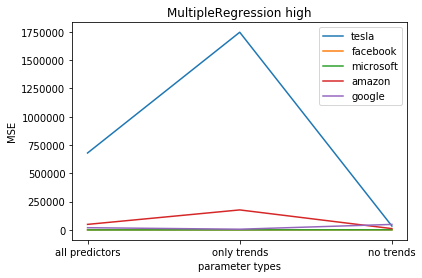

In [191]:
y_col = "high"
model = "MultipleRegression"
plotMSE(y_col, model)

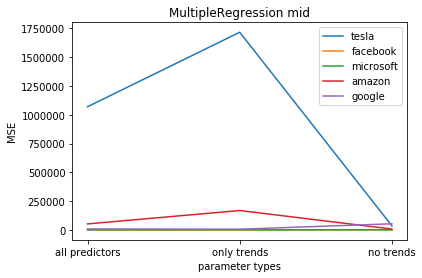

In [192]:
y_col = "mid"
model = "MultipleRegression"
plotMSE(y_col, model)



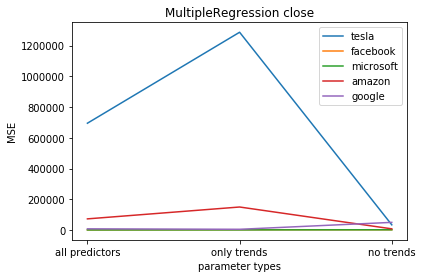

In [193]:
y_col = "close"
model = "MultipleRegression"
plotMSE(y_col, model)


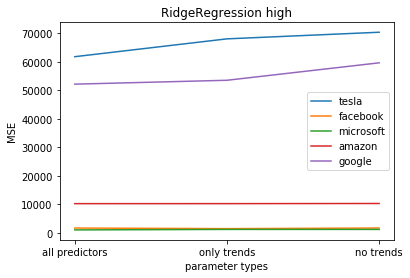

In [194]:
y_col = "high"
model = "RidgeRegression"
plotMSE(y_col, model)




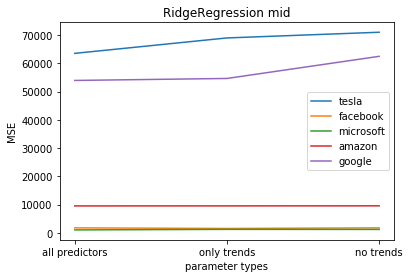

In [195]:
y_col = "mid"
model = "RidgeRegression"
plotMSE(y_col, model)



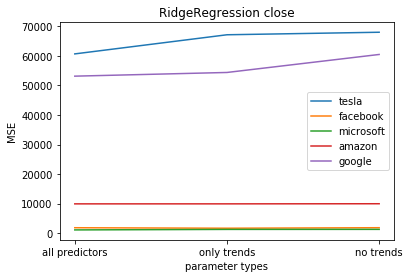

In [196]:
y_col = "close"
model = "RidgeRegression"
plotMSE(y_col, model)




## Tensorflow + Keras time

In [ ]:
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

In [ ]:
df_all_data['mid'] = (df_all_data['high'] + df_all_data['low'])/2
df_all_data[cols+['mid']]

In [ ]:
#scale data to be between 0-1 
sc = MinMaxScaler(feature_range = (0, 1))
data_set_scaled = sc.fit_transform(df_standardized_data[cols+['mid']])


In [ ]:
# Get training and test set
train = data_set_scaled[:50, :]
test = data_set_scaled[50:, :]
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

In [ ]:
# Create a sequential NN

model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')

In [ ]:
history = model.fit(train_X, train_y, epochs=500, batch_size=72, validation_data=(test_X, test_y), verbose=0, shuffle=False)

In [ ]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [ ]:
plt.plot(range(len(train_y)+len(test_y)) , list(np.array(train_y))+list(np.array(test_y)), range(len(train_y)), model.predict(train_X), '-', range(len(train_y), len(train_y)+len(test_y)), model.predict(test_X), '-')
plt.xlabel('Day')
plt.ylabel('Profit from previous day')
plt.title('Keras - Stock Market Mid per Day from 3 months until today')
plt.legend(["True Data","Training Data - Price change prediction", "Testing Data - Price change prediction"])
plt.show()

In [ ]:
df_stocks['microsoft']

In [ ]:
df_msft = df_stocks['microsoft'][['high', 'low']].iloc[::-1]
df_msft['mid'] = (df_msft['high'] + df_msft['low']) /2

In [ ]:
sc = MinMaxScaler(feature_range = (0, 1))
data_set_scaled = sc.fit_transform(df_msft[['high', 'low', 'mid']])

In [ ]:
train = data_set_scaled[:50, :]
test = data_set_scaled[50:, :]
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

In [ ]:
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')

In [ ]:
history = model.fit(train_X, train_y, epochs=500, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)

In [ ]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [ ]:
plt.plot(range(100) , list(np.array(train_y))+list(np.array(test_y)), range(50), model.predict(train_X), '-', range(50, 100), model.predict(test_X), '-')
plt.xlabel('Day')
plt.ylabel('Profit from previous day')
plt.title('MSFT Keras- Stock Market Mid per Day from 3 months until today')
plt.legend(["True Data","Training Data - Price change prediction", "Testing Data - Price change prediction"])
plt.show()

In [ ]:
msft_names = [x for x in list(df.columns.values) if 'microsoft' in x]
df_msft_trends = df[msft_names]
stock_times = df_stocks['microsoft'].times
trends_times = list(df_msft_trends.index)
joint_times = list(set(stock_times) & set(trends_times)) 
df_stocks['microsoft'] = df_stocks['microsoft'].loc[df_stocks['microsoft']['times'].isin(joint_times)]
df_stocks['microsoft'] = df_stocks['microsoft'].reset_index()
print(df_stocks['microsoft'].head())
df_msft_trends = df_msft_trends.loc[df_msft_trends.index.isin(joint_times)]
df_msft_trends = df_msft_trends.reset_index()
df_msft_trends.columns = ['_'.join(x.split()) for x in list(df_msft_trends.columns) if len(x) > 1]
print(df_msft_trends.head())
df_msft = df_msft_trends.join(df_stocks['microsoft'])
df_msft['profit'] = df_msft['open']-df_msft['close']
df_msft = df_msft.iloc[::-1]
df_msft.head()

In [ ]:
cols = ['microsoft_'+ x for x in key_terms]
df_msft['mid'] = (df_fb['high'] + df_fb['low'])/2
df_msft[cols+['high', 'low']+['mid']]

In [ ]:
sc = MinMaxScaler(feature_range = (0, 1))
data_set_scaled = sc.fit_transform(df_msft[cols+['high', 'low', 'mid']])

In [ ]:
train = data_set_scaled[:50, :]
test = data_set_scaled[50:, :]
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

In [ ]:
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')

In [ ]:
history = model.fit(train_X, train_y, epochs=500, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)

In [ ]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [ ]:
plt.plot(range(len(train_y)+len(test_y)) , list(np.array(train_y))+list(np.array(test_y)), range(50), model.predict(train_X), '-', range(50, len(train_y)+len(test_y)), model.predict(test_X), '-')
plt.xlabel('Day')
plt.ylabel('Profit from previous day')
plt.title('MSFT Keras- Stock Market Mid per Day from 3 months until today')
plt.legend(["True Data","Training Data - Price change prediction", "Testing Data - Price change prediction"])
plt.show()